## Задание для курсового проекта

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

- Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
- Необходимо получить R2 > 0.6

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

## 1.Загрузка данных

Работать будем у гугл коллабе. В качестве исходных данных возьмем датасет housing.csv с тетьего вебинара.

### Описание датасета

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

- longitude - долгота
- latitude - широта
- housing_median_age - средний возраст дома
- total_rooms - общее количество комнат
- total_bedrooms - общее количество спален
- population - количество проживающих
- households - домохозяйства
- ocean_proximity - близость океана
- median_income - средний доход
- median_house_value - средняя стоимость дома

In [29]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler

In [2]:
# Класс для предобработки исходных данных

class DataPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None

    def fit(self, df):
        """Сохранение статистик"""

        # Расчет медиан
        self.medians = df[['population', 'housing_median_age', 'total_bedrooms']].median()

    def transform(self, df):
        """Трансформация данных"""

        # 1. Пропуски
        df[['population', 'housing_median_age', 'total_bedrooms']] =\
            df[['population', 'housing_median_age', 'total_bedrooms']].fillna(self.medians)

        # 2. Выбросы (outliers)
        df = df[df['median_house_value'] < 500000]

        # 3. Обработка категорий
        df.replace({'ocean_proximity':{'-': df['ocean_proximity'].mode()[0]}},inplace=True)
        df = pd.concat([df, pd.get_dummies(df['ocean_proximity'],dtype=np.int64)], axis=1, )
        df.drop(['longitude','latitude','id','ocean_proximity'],axis=1, inplace=True)


        return df

In [3]:
# Функция для отображения целевой метрики R2

def stats_R2(train_values, train_pred_values, test_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_values, test_pred_values), 3)))

In [4]:
dataset = pd.read_csv('housing.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  19918 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20041 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  id                  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


### 2. Разведочный анализ данных(EDA).

Перед тем как разбить наш датасет на тренировочный и тестовый мы очистим и предобработаем его, чтобы отсутствующие или аномальные данные не искажали работу модели.

Вариантов как обработать данные множество. Мы можем удалить недостоверные или аномальные данные, можем создать отдельную модель для предсказания данных по схожим признакам, можем подключить сервисы геопозиционирования и на основании координат уточнить данные для заполнения пропусков.
Некоторые параметры вроде даты постройки имеют большее значение ,но без полноты данных о том проводилась ли реновация этих сооружений - делать однозначный выводы об оптимальных методах обработки данных сложно. Для выбора методов предобработки данных важны экспертные знания в конкретной области и даже конкретной территории застройки.


По этой причине мы выберем метод максимального сохранения данных и заполним все пропуски или аномалии медианным значениями для всей выборки.

Один градус широты или долготы соответствует до 110 км, потому делать какие то выводы зависимости цены от географических координат в рамках одного региона не будем - даже разница в одну сотую градуса сместит один изучаемый объект от другого на несколько километров в соверешнно другой район начеленного пункьта или за его пределы. Посчитаем что координаты нужны для формирования признака удаленности от океана ,который и будем исследовать.

Пропуски параметра ocean_proximity заполним модой всей выборки. Категориальные переменные преобразуем в числовые используя метод pd.get_dummies.

Проведем разведочный анализ для поиска зависимых параметров. По итогу работы напишем метод для предобработки данных и используя его получим уже рабочий датасет.

In [5]:
# Изучим статистические характеристики данных по каждому числовому признаку
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,20640.000000,20640.000000,19918.000000,20640.000000,20433.000000,20041.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.471242,35.036934,28.653630,2635.763081,537.870553,1425.418243,499.539680,3.870671,206855.816909,10319.500000
std,5.041408,94.903955,12.576796,2181.615252,421.385070,1135.185798,382.329753,1.899822,115395.615874,5958.399114
min,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,786.000000,280.000000,2.563400,119600.000000,5159.750000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1165.000000,409.000000,3.534800,179700.000000,10319.500000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1726.000000,605.000000,4.743250,264725.000000,15479.250000
max,122.030000,1327.130000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,20639.000000


In [6]:
# Посчитаем пропуски в данных
dataset.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,722
total_rooms,0
total_bedrooms,207
population,599
households,0
median_income,0
median_house_value,0
ocean_proximity,0


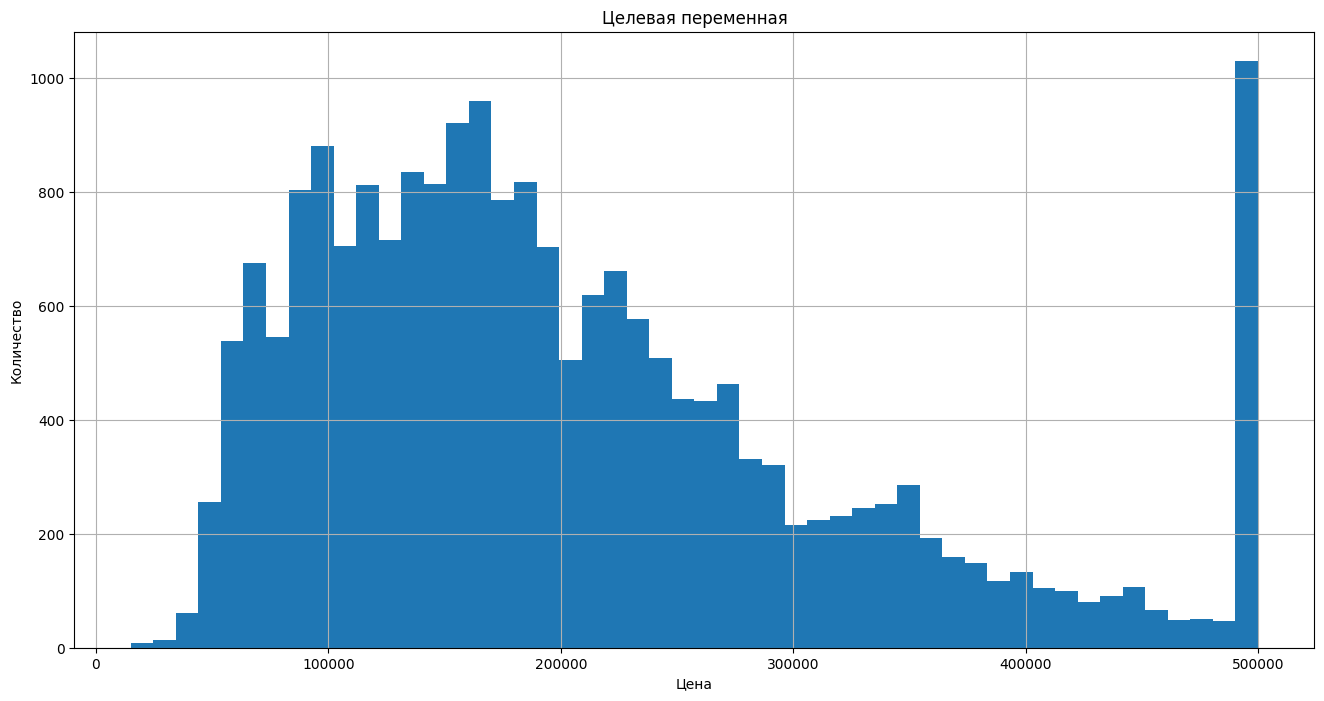

In [7]:
# Посмотрим на целевую переменную

plt.figure(figsize= (16,8))

dataset['median_house_value'].hist(bins=50)
plt.title('Целевая переменная')
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.show()

В целом для рынка недвижимости распределение близко к нормальному с длиным хвостом вправо ,характерным для элитной недвижисомти. Однако выброс на самом конце хвоста нужно изучить и удалить, так как он повлияет на точность предсказаний модели. Возможно эти объекты лучше отнести в отдельную категория и изучать вне имеющейся выборки.

In [8]:
# Сделаем копию датасета чтобы сохранить исходный от изменений и преобразований.
df = dataset.copy( deep = True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4


In [9]:
# Мы видим выброс в цене объектов. Изучим эти объекты более подробно.

dataset[(df['median_house_value'] > np.quantile(df['median_house_value'], q=0.952))]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,NEAR BAY,89
459,-122.25,37.87,52.0,609.0,236.0,1349.0,250.0,1.1696,500001.0,NEAR BAY,459
493,-122.24,37.86,52.0,1668.0,225.0,517.0,214.0,7.8521,500001.0,NEAR BAY,493
494,-122.24,37.85,52.0,3726.0,474.0,1366.0,496.0,9.3959,500001.0,NEAR BAY,494
509,-122.23,37.83,52.0,2990.0,379.0,947.0,361.0,7.8772,500001.0,NEAR BAY,509
...,...,...,...,...,...,...,...,...,...,...,...
20422,-118.90,34.14,35.0,1503.0,263.0,576.0,216.0,5.1457,500001.0,<1H OCEAN,20422
20426,-118.69,34.18,NaN,1177.0,138.0,415.0,119.0,10.0472,500001.0,<1H OCEAN,20426
20427,-118.80,34.19,4.0,15572.0,2222.0,5495.0,2152.0,8.6499,500001.0,<1H OCEAN,20427
20436,-118.69,34.21,10.0,3663.0,409.0,1179.0,371.0,12.5420,500001.0,<1H OCEAN,20436


In [10]:
dataset[((df['median_house_value'] > 490000) & (df['median_house_value']< 500000)) ].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
1581,-122.03,37.86,25.0,3004.0,393.0,1145.0,376.0,7.2655,494000.0,NEAR BAY,1581
1639,-122.18,37.89,18.0,4845.0,735.0,1634.0,734.0,8.1489,499000.0,NEAR BAY,1639
4068,-118.48,34.15,31.0,2536.0,429.0,990.0,424.0,5.4591,495500.0,<1H OCEAN,4068
4076,-118.45,34.14,33.0,1741.0,274.0,588.0,267.0,7.9625,490800.0,<1H OCEAN,4076
4106,-118.36,34.13,36.0,6871.0,1180.0,2216.0,1130.0,8.0499,495600.0,<1H OCEAN,4106


У нас есть 965 объекта с аномальной ценой больше 500000 и квантиля 0,952, притом остальные параметры объектов кратно отличаются между собой при одной и той же стоимости объекта.

Можно сделать вывод что это однозначно недостоверные данные добавлены в качестве примера для обучении поиска аномалий.
Удалим эти данные так как они некорректы и не информативны.

In [11]:
# Мы видим аномалию в распределения объектов по параметру total_rooms ,которая превышает среднее значение в 15 раз

dataset[(df['total_rooms'] > np.quantile(df['total_rooms'], q=0.975))]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
283,-122.16,37.79,22.0,12842.0,2048.0,4985.0,1967.0,5.9849,371000.0,NEAR BAY,283
570,-122.24,37.72,5.0,18634.0,2885.0,7427.0,2718.0,7.6110,350700.0,NEAR BAY,570
576,-122.06,37.77,12.0,14316.0,2045.0,5781.0,2007.0,7.2634,341600.0,NEAR BAY,576
706,-122.04,37.65,10.0,8299.0,1326.0,3827.0,1288.0,6.2579,315500.0,NEAR BAY,706
780,-122.10,37.63,18.0,9963.0,2031.0,5613.0,1946.0,3.8171,187200.0,NEAR BAY,780
...,...,...,...,...,...,...,...,...,...,...,...
20530,-121.76,38.57,11.0,15018.0,3008.0,7984.0,2962.0,3.1371,201800.0,INLAND,20530
20539,-121.71,38.56,20.0,8627.0,1516.0,4071.0,1466.0,4.2198,164100.0,INLAND,20539
20544,-121.76,38.55,23.0,8800.0,1857.0,6330.0,1832.0,2.0650,219400.0,INLAND,20544
20563,-121.75,38.67,9.0,12139.0,2640.0,6837.0,2358.0,3.1250,132500.0,INLAND,20563


In [12]:
dataset[(df['total_rooms'] > 30000)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
6057,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN,6057
9019,-118.78,34.16,9.0,30405.0,4093.0,12873.0,3931.0,8.0137,399200.0,NEAR OCEAN,9019
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN,9880
10309,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN,10309
12201,-117.20,33.58,2.0,30450.0,5033.0,9419.0,3197.0,4.5936,174300.0,<1H OCEAN,12201
12215,-117.12,33.52,4.0,30401.0,4957.0,13251.0,4339.0,4.5841,212300.0,<1H OCEAN,12215
13139,-121.44,38.43,NaN,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND,13139


Text(0.5, 0, 'Всего комнат')

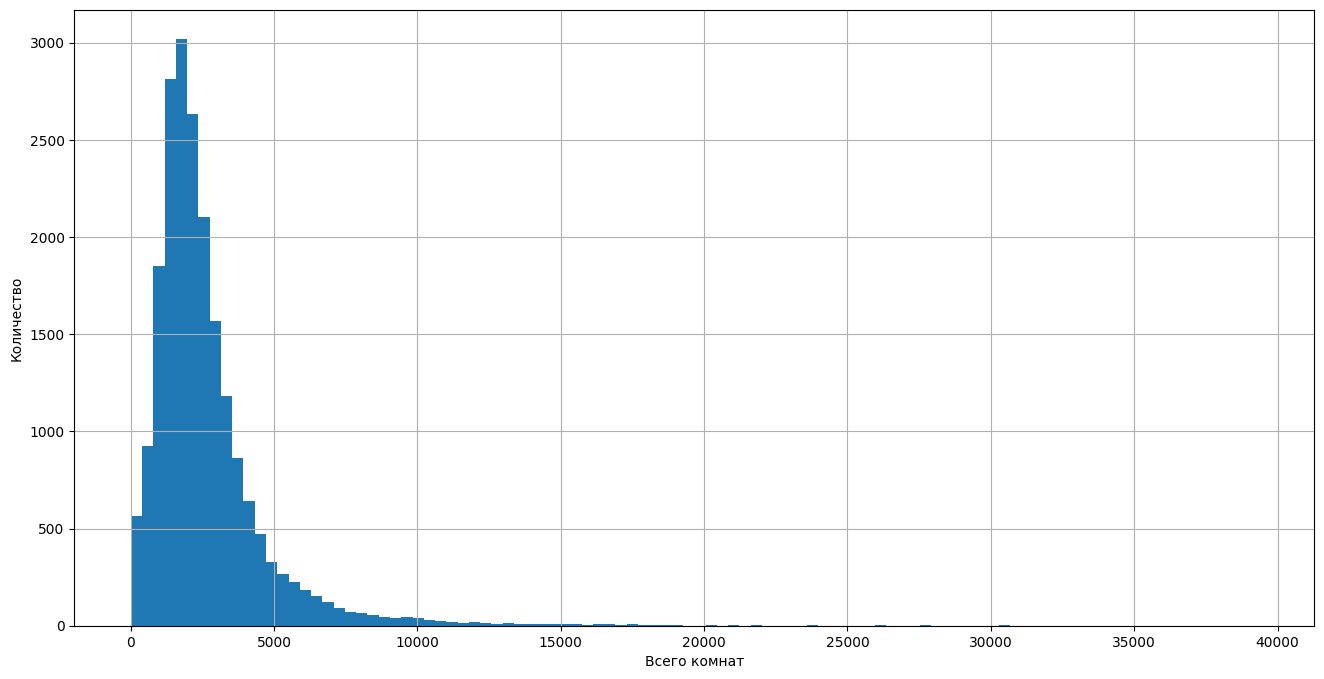

In [13]:
plt.figure(figsize= (16,8))

df['total_rooms'].hist(bins=100)
plt.ylabel('Количество')
plt.xlabel('Всего комнат')

В выборке присутствуют 516 объектов за quantile= 0.975 и 7 объектов с количеством комнат более 30000. Однако соотношение всех комнат к спальням и среднее количество проживающих в каждой комнате для этих объектов находится в диапазоне характерном для всей выборки. Можно посчитать эти объекты многоквартирными или гостиничными комплексами с характеристиками  типичными для региона и не являющиеся аномалиями.

У нас есть конкретное задание и целевая метрика R2 > 0.6. Оставим эти данные в выборке. Если искомого результат не удастся достигнуть, тогда уберем эти данные и обучим модель уже без них.

In [14]:
dataset[(df['total_rooms'] < 20)].head(15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY,73
3125,-117.76,35.22,4.0,18.0,3.0,8.0,6.0,1.6250,275000.0,INLAND,3125
3126,-117.79,35.21,4.0,2.0,2.0,6.0,2.0,2.3750,137500.0,INLAND,3126
5342,-118.44,34.04,16.0,18.0,6.0,3.0,4.0,0.5360,350000.0,<1H OCEAN,5342
5916,-118.44,34.28,46.0,11.0,11.0,24.0,13.0,2.8750,162500.0,<1H OCEAN,5916
7125,-118.04,33.90,36.0,15.0,5.0,15.0,6.0,0.4999,162500.0,<1H OCEAN,7125
12286,-116.95,33.86,1.0,6.0,2.0,8.0,2.0,1.6250,55000.0,INLAND,12286
12458,-114.62,33.62,26.0,18.0,3.0,5.0,3.0,0.5360,275000.0,INLAND,12458
14822,-117.12,32.66,52.0,16.0,4.0,8.0,3.0,1.1250,60000.0,NEAR OCEAN,14822
16171,-122.50,37.79,52.0,8.0,1.0,13.0,1.0,15.0001,500001.0,NEAR BAY,16171


In [15]:
dataset[(df['total_rooms'] < 200)].count()

,0
longitude,251
latitude,251
housing_median_age,241
total_rooms,251
total_bedrooms,250
population,244
households,251
median_income,251
median_house_value,251
ocean_proximity,251


Мы изучили все остальные аномалии в выборке и приняли решение оставить их, так как количественно эти объекты занимают доли процента, а соотношение между параметрами и ценой находятся в диапазоне типичном для всей выборки. Будем считать такие объекты особенностью рынка недвижимости в этом регионе.

Единственный выброс который мы удалим из выборки это объекты недвижимости с ценой выше 500000 или лежащими за 0.952 квантилем.

Мы напишем собственный класс DataPipeline для предобработки данных в методах которого мы удалим ненужные данные и выбросы, заполним пропуски медианными значениям и преобразуем строковые признаки в количественное представление.

In [16]:
# Очистим данные

pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)
df.head()

<ipython-input-2-306e4d5f74fb>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({'ocean_proximity':{'-': df['ocean_proximity'].mode()[0]}},inplace=True)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [17]:
df.isna().sum()

,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
<1H OCEAN,0
INLAND,0
ISLAND,0


In [18]:
# Выделим целевой признак и разделим датасет на тестовый и тренировочный.

X = df.drop('median_house_value', axis=1)
y = df['median_house_value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12794,20.0,1517.0,323.0,1287.0,328.0,1.6607,0,1,0,0,0
14570,35.0,2259.0,501.0,1340.0,511.0,3.4482,0,0,0,0,1
9328,35.0,908.0,194.0,413.0,197.0,3.9917,0,0,0,1,0
5102,41.0,1353.0,286.0,751.0,250.0,2.7401,1,0,0,0,0
1822,32.0,1736.0,234.0,602.0,231.0,6.5160,0,0,0,1,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19648 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  19648 non-null  float64
 1   total_rooms         19648 non-null  float64
 2   total_bedrooms      19648 non-null  float64
 3   population          19648 non-null  float64
 4   households          19648 non-null  float64
 5   median_income       19648 non-null  float64
 6   median_house_value  19648 non-null  float64
 7   <1H OCEAN           19648 non-null  int64  
 8   INLAND              19648 non-null  int64  
 9   ISLAND              19648 non-null  int64  
 10  NEAR BAY            19648 non-null  int64  
 11  NEAR OCEAN          19648 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 1.9 MB


In [20]:
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000
mean,28.407370,2620.337693,538.580619,1433.263080,501.192488,3.676411,192055.328583,0.438162,0.331535,0.000254,0.106169,0.123880
std,12.275588,2182.371939,420.528043,1130.881034,383.391367,1.570602,97110.854998,0.496174,0.470777,0.015951,0.308061,0.329453
min,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1438.000000,299.000000,807.000000,282.000000,2.526300,116475.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2111.000000,435.000000,1165.000000,411.000000,3.449050,173600.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,3121.000000,644.250000,1722.000000,606.000000,4.582500,247900.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,499100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Мы получили чистые данные в которых есть только числовые признаки.
Визуализируем числовые признаки и изучим их распределение.

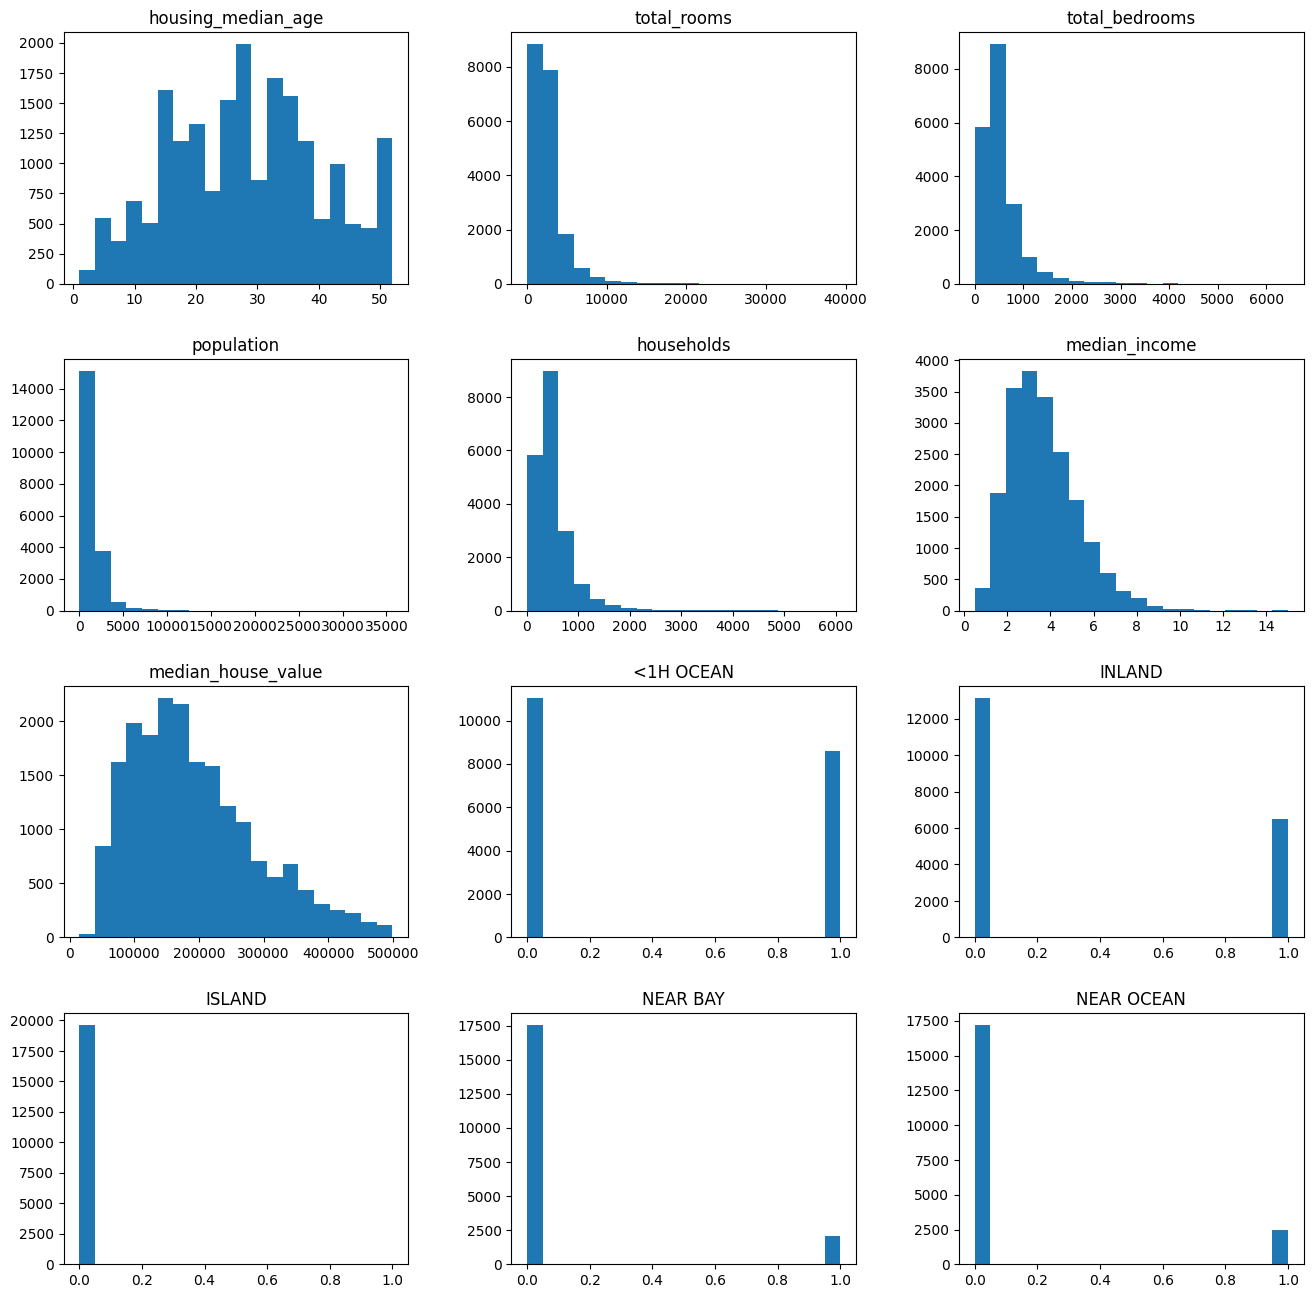

In [21]:
df.hist(figsize=(16,16), bins=20, grid=False);

<Axes: >

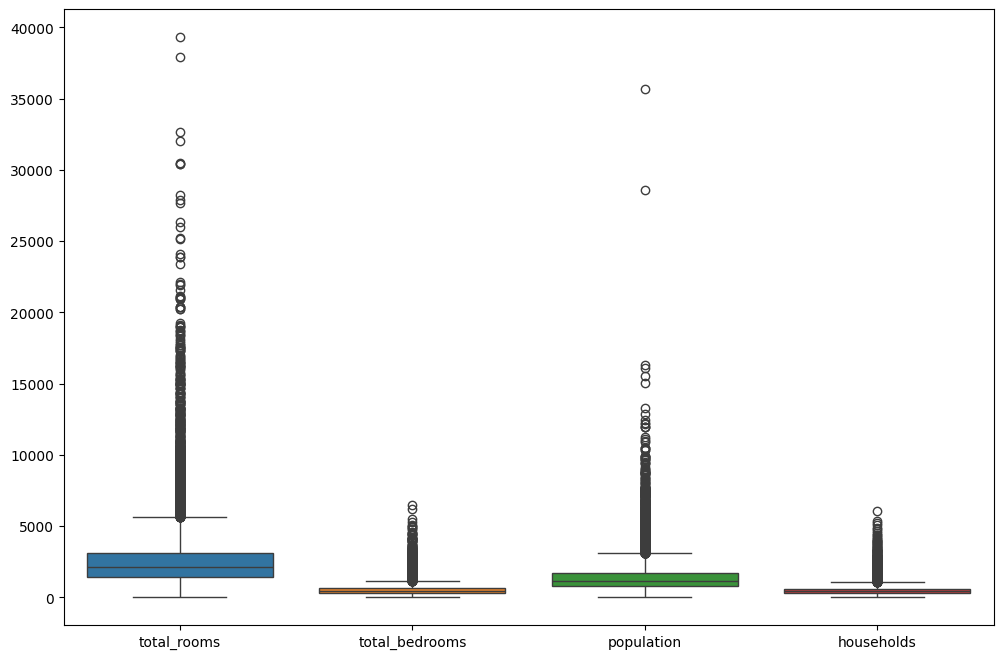

In [22]:
signs_lst = ['total_rooms', 'total_bedrooms', 'population', 'households']
plt.figure(figsize=(12, 8))
sns.boxplot(df[signs_lst])

Мы имеем распределение близкое к нормальному с длинным правым плечом. Стандартные методы статистики говорят о том что нам нужно удалить данные распределенные за максимумы. Однако учитывая специфику рынка недвижимости и наличие на нем уникальных предложений, мы сохраним эти данные для обучения модели.

Посмотрим матрицу корреляции и изучим зависимые параметры.

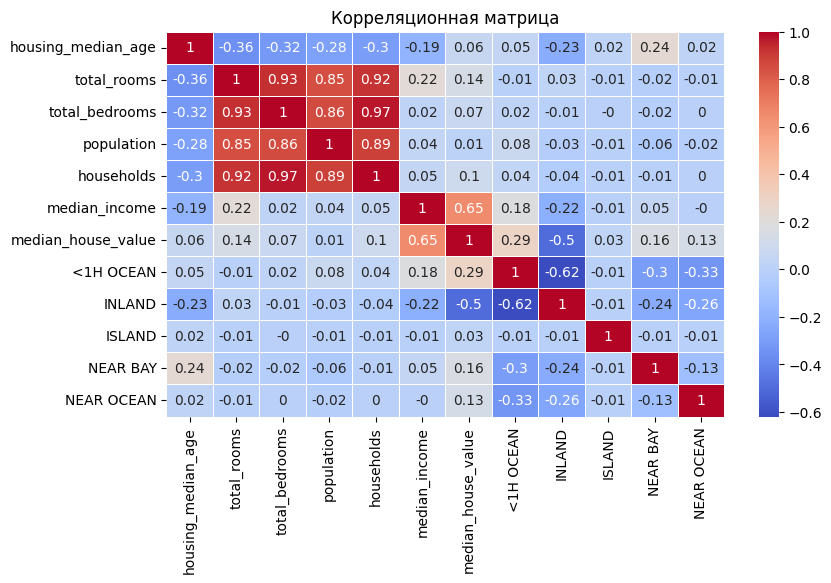

In [23]:
# Округлим данные до двух знаков после запятой

corr_m = df.corr().round(2)

plt.figure(figsize = (9, 5))
plt.title('Корреляционная матрица')
sns.heatmap(corr_m, annot = True, linewidths=.5, cmap='coolwarm')
plt.show()

Предварительный анализ матрицы корреляций дает неоднозначные выводы.


Стат значимая связь целевой переменной есть только с двумя параметрами - это средний доход домохозяйства и удаленность от океана.
Знание того что люди с большим доходом покупают более дорогое жилье можно получить без серьезных исследований.

Корелляция данных между количеством спален и общим кеоличеством комнат, а так же связь общего количества проживающих с общим количествои комнат - выглядят достоверно, но не дают нам полезных знаний для прогнозирования целевой характеристики.

Так же удивляет низкая корреляция цены объекта со средним сроком постройки.

### 3. Создание модели
Выделим целевой признак и разделим датасет на тестовый и тренировочный. После чего приступим к построению модели.

Мы провели множественные исследования различных методов и моделей при подборе оптимальной для предсказания целевой переменной. Провели GridSearchCV и кроссвалидацию. Провели обучение с базовым датасетом и с нормализованными/масштабированными признаками.

По условию задания в итоговой работе мы оставим только лучшую модель соответствующую поставленной цели.

In [24]:
# Выделим целевой признак и разделим датасет на тестовый и тренировочный

X = df.drop('median_house_value', axis=1)
y = df['median_house_value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12794,20.0,1517.0,323.0,1287.0,328.0,1.6607,0,1,0,0,0
14570,35.0,2259.0,501.0,1340.0,511.0,3.4482,0,0,0,0,1
9328,35.0,908.0,194.0,413.0,197.0,3.9917,0,0,0,1,0
5102,41.0,1353.0,286.0,751.0,250.0,2.7401,1,0,0,0,0
1822,32.0,1736.0,234.0,602.0,231.0,6.5160,0,0,0,1,0


In [43]:
modelRFG = RandomForestRegressor(n_estimators=1000,random_state = 42)

In [44]:
modelRFG.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [45]:
y_pred = modelRFG.predict(X_test)
r2(y_test, y_pred)

0.6561066787961669

In [46]:
y_train_preds = modelRFG.predict(X_train)
y_valid_preds = modelRFG.predict(X_test)

# посмотрим статистическую метрику R2
stats_R2(y_train, y_train_preds, y_test, y_valid_preds)

Train R2:	0.955
Test R2:	0.656


Мы получили искомую метрику в допустимом диапазоне. Однако точность предсказания для тестовых данных равная 0.654 явна недостаточна для реального использования. Попробуем улучшить модель.

In [30]:
# Используем метод кросс-валидации для улучшения предсказания

cv = cross_validate(modelRFG, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

In [31]:
print(f'Метрике r2: {cv["test_score"].mean()}')

Метрике r2: 0.6573196438952001


In [32]:
# Изучим вес каждого признака в текущей модели

feature_imp = modelRFG.feature_importances_
feature_imp

array([0.068882  , 0.0405773 , 0.05560552, 0.07310393, 0.04492766,
       0.51936301, 0.00393807, 0.18449491, 0.00102321, 0.00302271,
       0.00506168])

Мы подтверждаем результат полученный в EDA о корреляции целевой переменной с признаками дохода домохозяйства и отрицательной зависимости цены от удаленности от побережья.

Проведем стандартизацию данных в попытке улучшить модель.

In [33]:
scaler = StandardScaler()

In [34]:
# Cохраним заголовки датасета в отдельном списке
column_names = X_train.columns.tolist()
column_names

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [35]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=column_names)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=column_names)

In [36]:
X_test_scaled

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.380976,-0.381857,-0.448301,-0.517414,-0.346603,0.875508,1.117266,-0.700639,0.0,-0.330499,-0.382239
1,0.646529,-0.440791,-0.617044,-0.654315,-0.474175,0.699327,1.117266,-0.700639,0.0,-0.330499,-0.382239
2,-0.822364,-0.050117,-0.396944,-0.250315,-0.316746,0.747644,1.117266,-0.700639,0.0,-0.330499,-0.382239
3,-1.638416,1.405641,2.386086,2.050182,2.375830,-0.376379,1.117266,-0.700639,0.0,-0.330499,-0.382239
4,1.952212,0.049215,0.588610,0.013911,0.635970,-0.041297,-0.895042,-0.700639,0.0,3.025729,-0.382239
...,...,...,...,...,...,...,...,...,...,...,...
3925,1.952212,-0.274446,-0.245321,0.741493,-0.219031,-0.000595,-0.895042,-0.700639,0.0,3.025729,-0.382239
3926,-1.230390,-0.290605,-0.399390,-0.644741,-0.517603,-0.507251,-0.895042,1.427268,0.0,-0.330499,-0.382239
3927,1.952212,-0.684605,-0.741766,-0.691651,-0.721175,-1.316926,-0.895042,-0.700639,0.0,3.025729,-0.382239
3928,-0.903970,1.305359,1.940997,1.538003,2.082686,-1.111308,-0.895042,-0.700639,0.0,-0.330499,2.616163


In [37]:
modelRFG.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)

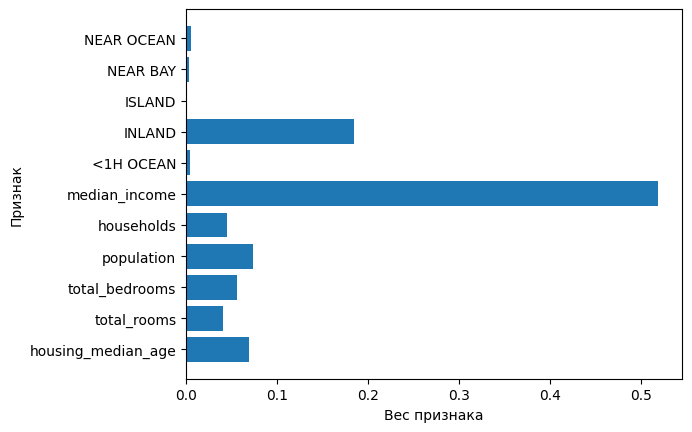

In [38]:
# Посмотрим изменился ли вес признаков после стандартизации

plt.barh(column_names, modelRFG.feature_importances_)
plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [39]:
y_train_preds = modelRFG.predict(X_train_scaled )
y_valid_preds = modelRFG.predict(X_test_scaled )

# посмотрим статистическую метрику R2 для модели обученной на стандартизированных данных

stats_R2(y_train, y_train_preds, y_test, y_valid_preds)

Train R2:	0.844
Test R2:	0.646


## 4. Выводы

1. Мы достигли поставленной задачи и обучили модель с достаточной прогностической силой удовлетворяющей целевой метрике R2 равной 0.656 для тестовых данных.
2. Однако считать этот результат приемлемым и пригодным к реальному использованию невозможно.
3. Причиной непригодности полученной модели является базовая неполнотаданных в исследуемом датасете.
4. Основным параметром влияющим на цену яыляется median_income. Это логичная связь, но этот параметр никак не связан с характеристиками самого объекта недвижимости, а лишь отображает конечный факт покупки более богатыми клиентами более дорогого объекта недвижимости.
5. Вторым по значимости параметром является критерий удаленности от побережья, что может считаться правдоподобным - но явно недостаточным для ключевого влияния на цену.
6. В рамках этой работы были предприняты разные формы предобработки данных, создание новых признаков на основе имеющихся, опробованы разные модели с разными параметрами. Но ни одна из методик не привела к качественному улучшению предсказаний модели, лишь в какой то степени подгоняла результат к цели. Потому выбрана самая малозатратная по ресурсам модель.
7. Можно сделать предположение что для оценки реального объекта недвижимости нужно куда больше данных как по самому объекту недвижимости, так и по окружающему его пространству и наличие социальных объектов, спроса и предложения в районе, наличие работы и множеству других параметров реально значимых для конечного клиента.
8. Делать предположения о цене недвижимости на основании географических координат, дохода клиентов попавших с статистику - не продуктивно.  
9. Итогом выполненной работы может быть констатация факта того что исследуемый датасет подходит только для целей обучения, но строить на его основе какие либо модели для практического применения неэффективно.
